# Verkenning en schoonmaken van de onbeschikbare geneesmiddelen 


In [1]:
import pandas as pd
from datetime import datetime as dt
import os

## Stap één: verkenning
Het eerste wat we gaan doen is de dataset inlezen en bekijken. We maken de columns mooi en isoleren de naam van het geneesmiddel om die later makkelijker terug te kunnen zoeken. Ook isoleren we het jaar van de startdatum om hier later makkelijker op te kunnen filteren.

In [2]:
data = pd.read_csv(os.path.expanduser('~/Desktop/vrtnws_data/zorg/supplyproblems.csv'), parse_dates=['Supply Problem Start Date', 'Supply Problem End Date'], dayfirst=True, error_bad_lines=True)
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '')
data = data[data['human/veterinary'] == 'human']
data['name'] = data.name_medicinal_product.str.split().str.get(0)
data['start_year'] = pd.to_datetime(data.supply_problem_start_date, format='%Y-%m-%d').dt.year

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5030 entries, 0 to 5626
Data columns (total 14 columns):
name_medicinal_product              5030 non-null object
pharmaceutical_form                 5030 non-null object
packaging_type                      5027 non-null object
pack_size                           5029 non-null object
mah                                 5030 non-null object
supply_problem_start_date           5030 non-null datetime64[ns]
supply_problem_presumed_end_date    3498 non-null object
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3634 non-null object
authorisation_number                5030 non-null object
cti_extended                        5030 non-null object
human/veterinary                    5030 non-null object
name                                5030 non-null object
start_year                          5030 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 589.5+ KB


In [4]:
data.head()

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name,start_year
0,Amoxypen 1 g,Effervescent tablet,Tube,20 (2 x 10),Amophar,2015-01-01,NaN,2016-02-01,NaN,BE218127,218127-05,human,Amoxypen,2015
1,Amoxypen 1 g,Effervescent tablet,Tube,8,Amophar,2015-01-01,NaN,2016-02-01,NaN,BE218127,218127-01,human,Amoxypen,2015
2,Buccalin,Tablet,Packaging,7,Desma,2015-01-01,NaN,2015-11-11,NaN,BE079274,079274-01,human,Buccalin,2015
3,Desloratadine Actavis 5 mg,Film-coated tablet,Blister,50,Actavis Group Ptc Ehf,2015-01-01,NaN,2015-01-01,NaN,EU/1/11/745/007,413244-01,human,Desloratadine,2015
4,Desloratadine Actavis 5 mg,Film-coated tablet,Blister,100,Actavis Group Ptc Ehf,2015-01-01,NaN,2015-01-01,NaN,EU/1/11/745/009,413262-01,human,Desloratadine,2015


## Stap twee: schoonmaken
Het volgende dat we willen doen is de dataset schoonmaken. Er is namelijk een grote kans dat er fouten in de dataset zitten. Van degene van wie de dataset hebben gekregen, begrepen we dat er geen geneesmiddelen in de dataset moeten zitten die nog onbeschikbaar waren op 12-8-2019. Dit kunnen we controleren omdat we van de info weten dat er een column is met de 'supply problem end date'. Hier zouden dus geen lege waardes in moeten zitten.

In [5]:
len(data[data.supply_problem_end_date.isna()])

563

En nu blijkt dus dat we alsnog 563 geneesmiddelen hebben waar een einddatum ontbreekt. We gaan deze subset opslaan in een variabele om beter te kunnen bekijken.

In [6]:
no_end = data[data.supply_problem_end_date.isna()]

## Stap drie: cross-referencing
Van de website van het FAGG hebben we nog twee andere datasets gehaald, namelijk de dataset met momenteel onbeschikbare geneesmiddelen en de dataset met de historiek van wijzigingen, gebaseerd op informatie van de afgelopen 30 dagen. Deze wordt dus elke dag aangepast. De historiek-dataset is gedownload op 23-10-2019. We kunnen deze twee datasets gebruiken om de geneesmiddelen zonder einddatum mee te cross-checken. Wellicht dat er, ondanks het bericht dat we kregen, alsnog geneesmiddelen in de dataset zitten die nog altijd onbeschikbaar zijn. 

In [7]:
current = pd.read_csv(os.path.expanduser('~/Desktop/vrtnws_data/zorg/current.csv'), parse_dates=['SUPPLY PROBLEM START DATE', 'SUPPLY PROBLEM EXPECTED END DATE'], dayfirst=True)
current.columns = current.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '')
changes = pd.read_csv('~/Desktop/vrtnws_data/zorg/changes.csv', parse_dates=['BEGINDATUM ONBESCHIKBAARHEID'], dayfirst=True)
changes.columns = changes.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '')

Ook deze datasets kunnen fouten bevatten. Een veel voorkomende fout in datasets zijn ontbrekende dan wel duplicate waardes. Daarom moeten we op zoek naar een unieke ID om te controleren of onze datasets dubbele waardes bevatten. Daarvoor moeten we de info van de datasets bekijken. 

In [8]:
current.info()

changes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 13 columns):
name                                558 non-null object
authorisation_holder                558 non-null object
pharmaceutical_form                 558 non-null object
packaging_type                      558 non-null object
pack_size                           558 non-null object
cti_extended                        558 non-null object
cnk                                 558 non-null object
fmd_code                            558 non-null object
supply_problem_start_date           558 non-null datetime64[ns]
supply_problem_expected_end_date    557 non-null datetime64[ns]
supply_problem_reason               558 non-null object
parallel_distributor                0 non-null float64
derogation                          558 non-null object
dtypes: datetime64[ns](2), float64(1), object(10)
memory usage: 56.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data co

Hier zien we dat beide datasets de column 'cti_extended' bevat, en als we terugscrollen zien we dat onze oorspronkelijke dataset deze ook bevat. Een rondje op Google leert ons dat CTI Extended een unieke code is die het FAGG aan een bepaalde verpakkingstype van een bepaald geneesmiddel meegeeft. Dat is dus precies wat we zoeken. 

In [9]:
len(current.index)

558

In [10]:
current.cti_extended.nunique()

558

In [11]:
len(changes.index)

602

In [12]:
changes.cti_extended.nunique()

482

Uit bovenstaande zien we dat de huidige onbeschikbare geneesmiddelen allemaal uniek zijn, terwijl er in de changes-dataset wel duplicaten zitten. Dit kan te verklaren zijn, maar we gaan die dataset voor nu wel even parkeren en beginnen met de current-dataset. We gaan kijken of er onder de geneesmiddelen zonder einddatum wellicht geneesmiddelen zitten die nu nog onbeschikbaar zijn. Dat doen we door de twee datasets te mergen en te kijken of er rijen zijn die in beide datasets voorkomen. Eerst moeten we controleren of de datasets een beetje te vergelijken zijn. Dat ze dezelfde columnnamen hebben wil niet zeggen dat ze ook op dezelfde manier de data hebben ingevoerd. 

In [13]:
no_end.head()

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name,start_year
1591,Midazolam Mylan 5 mg/ml,Solution for injection,Ampoule,10 x 10 ml,Mylan,2016-12-30,2017-02-03,NaT,New batch(es) not yet available,BE339403,339403-04,human,Midazolam,2016
1616,"Zolmitriptan Teva Instant 2,5 mg",Orodispersible tablet,Blister,3,Teva Pharma Belgium,2017-01-05,2017-06-15,NaT,New batch(es) not yet available,BE365836,365836-02,human,Zolmitriptan,2017
1672,Lansoprazol Sandoz 30 mg,"Gastro-resistant capsule, hard",Bottle,56,Sandoz,2017-01-20,2017-01-27,NaT,NaN,BE281967,281967-03,human,Lansoprazol,2017
1702,Lidocaine Accord 20 mg/ml,Solution for injection,Ampoule,20 x 10 ml,Accord Healthcare,2017-02-01,2017-05-15,NaT,New batch(es) not yet available,BE479342,479342-02,human,Lidocaine,2017
1703,Lorazetop 1 mg,Tablet,Blister,60,Apotex Europe,2017-02-01,2019-02-01,NaT,Production problems,BE193602,193602-03,human,Lorazetop,2017


In [14]:
current.head()

,name,authorisation_holder,pharmaceutical_form,packaging_type,pack_size,cti_extended,cnk,fmd_code,supply_problem_start_date,supply_problem_expected_end_date,supply_problem_reason,parallel_distributor,derogation
0,"""Aacidexam 5 mg/ml""",Aspen Pharma Trading Ltd (IE),Solution for injection,"""Ampoule""",1 ml,080026-01,"""1750132""","""05060249176732""",2019-09-30,2019-12-07,Production problems,NaN,no
1,"""Abacavir/Lamivudin Sandoz 600 mg - 300 mg""",Sandoz NV (BE),Film-coated tablet,"""Blister""",30,500622-01,"""3550647""","""07613421010430""",2019-03-01,2020-01-15,New batch(es) not yet available,NaN,no
2,"""Accupril 40 mg""",Pfizer SA (BE),Film-coated tablet,"""Blister""",56,150963-01,"""1578129""","""05415062302880""",2019-08-22,2019-12-15,New batch(es) not yet available,NaN,no
3,"""Accuretic 10 mg - 12,5 mg""",Pfizer SA (BE),Film-coated tablet,"""Blister""",28,164367-01,"""1088673""","""05415062302903""",2019-06-12,2019-10-31,New batch(es) not yet available,NaN,no
4,"""Accuretic 20 mg - 12,5 mg""",Pfizer SA (BE),Film-coated tablet,"""Blister""",28,164376-01,"""1088681""","""05415062302910""",2018-11-22,2019-11-10,New batch(es) not yet available,NaN,no


Er vallen een aantal dingen op. Zo hebben in de current-dataset een aantal waardes (name, packaging type) apostrofs om de inhoud gekregen. Dat maakt het onmogelijk om deze waardes te vergelijken met de andere dataset. We kunnen dit oplossen door de dataset aan te passen.

In [15]:
current['name'] = current.name.str.replace('"', '')
current['packaging_type'] = current.packaging_type.str.replace('"', '')

In [16]:
current.head()

,name,authorisation_holder,pharmaceutical_form,packaging_type,pack_size,cti_extended,cnk,fmd_code,supply_problem_start_date,supply_problem_expected_end_date,supply_problem_reason,parallel_distributor,derogation
0,Aacidexam 5 mg/ml,Aspen Pharma Trading Ltd (IE),Solution for injection,Ampoule,1 ml,080026-01,"""1750132""","""05060249176732""",2019-09-30,2019-12-07,Production problems,NaN,no
1,Abacavir/Lamivudin Sandoz 600 mg - 300 mg,Sandoz NV (BE),Film-coated tablet,Blister,30,500622-01,"""3550647""","""07613421010430""",2019-03-01,2020-01-15,New batch(es) not yet available,NaN,no
2,Accupril 40 mg,Pfizer SA (BE),Film-coated tablet,Blister,56,150963-01,"""1578129""","""05415062302880""",2019-08-22,2019-12-15,New batch(es) not yet available,NaN,no
3,"Accuretic 10 mg - 12,5 mg",Pfizer SA (BE),Film-coated tablet,Blister,28,164367-01,"""1088673""","""05415062302903""",2019-06-12,2019-10-31,New batch(es) not yet available,NaN,no
4,"Accuretic 20 mg - 12,5 mg",Pfizer SA (BE),Film-coated tablet,Blister,28,164376-01,"""1088681""","""05415062302910""",2018-11-22,2019-11-10,New batch(es) not yet available,NaN,no


We zien dat we dat probleem nu hebben opgelost. Op deze manier kunnen we gaan mergen. We mergen de dataset in ieder geval op de cti_extended waarde én op de startdatum van de supply problems, om de kans te vergroten dat we dezelfde rijen te pakken hebben. We voegen ook een indicator toe, waar we op kunnen filteren als we willen zien welke rijen in beide datasets voorkomen. We doen een left join, omdat we ook willen weten welke waardes niet in beide datasets voorkomen, maar wel in de no_end dataset. 

In [17]:
merged = pd.merge(no_end, current, on=['cti_extended', 'supply_problem_start_date'], how='left', indicator='exists')

In [18]:
merged.head()

,name_medicinal_product,pharmaceutical_form_x,packaging_type_x,pack_size_x,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason_x,authorisation_number,...,pharmaceutical_form_y,packaging_type_y,pack_size_y,cnk,fmd_code,supply_problem_expected_end_date,supply_problem_reason_y,parallel_distributor,derogation,exists
0,Midazolam Mylan 5 mg/ml,Solution for injection,Ampoule,10 x 10 ml,Mylan,2016-12-30,2017-02-03,NaT,New batch(es) not yet available,BE339403,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,left_only
1,"Zolmitriptan Teva Instant 2,5 mg",Orodispersible tablet,Blister,3,Teva Pharma Belgium,2017-01-05,2017-06-15,NaT,New batch(es) not yet available,BE365836,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,left_only
2,Lansoprazol Sandoz 30 mg,"Gastro-resistant capsule, hard",Bottle,56,Sandoz,2017-01-20,2017-01-27,NaT,NaN,BE281967,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,left_only
3,Lidocaine Accord 20 mg/ml,Solution for injection,Ampoule,20 x 10 ml,Accord Healthcare,2017-02-01,2017-05-15,NaT,New batch(es) not yet available,BE479342,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,left_only
4,Lorazetop 1 mg,Tablet,Blister,60,Apotex Europe,2017-02-01,2019-02-01,NaT,Production problems,BE193602,...,Tablet,Blister,60,"""3215894""","""08712755216002""",2019-12-31,Temporary suspension of the commercialisation,NaN,no,both


In [19]:
merged.exists.value_counts()

left_only     292
both          271
right_only      0
Name: exists, dtype: int64

We zien dat er 271 rijen zijn die in beide datasets voorkomen. Om zeker te weten dat we allemaal rijen hebben die inderdaad hetzelfde zijn, mergen we nog een keer maar dan met twee extra variabeles.

In [20]:
pd.merge(no_end, current, on=['cti_extended', 'supply_problem_start_date', 'packaging_type', 'pharmaceutical_form'], how='left', indicator='exists').exists.value_counts()

left_only     296
both          267
right_only      0
Name: exists, dtype: int64

We zien dat er een verschil is van vier waardes. Al we willen weten welke waardes dat zijn moeten we de twee datasets met elkaar vergelijken om het verschil te zien. Dat doen we door eerst van beide datasets de rijen te isoleren die in beide sets zouden voorkomen. 

In [21]:
merged_2 = pd.merge(no_end, current, on=['cti_extended', 'supply_problem_start_date', 'packaging_type', 'pharmaceutical_form'], how='left', indicator='exists')

In [22]:
both = merged[merged.exists == 'both']
both_2 = merged_2[merged_2.exists == 'both']

In [23]:
pd.concat([both, both_2]).loc[
    both.index.symmetric_difference(both_2.index)
]

/Users/fmeijer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,authorisation_holder,authorisation_number,cnk,cti_extended,derogation,exists,fmd_code,human/veterinary,mah,name_medicinal_product,...,pharmaceutical_form,pharmaceutical_form_x,pharmaceutical_form_y,start_year,supply_problem_end_date,supply_problem_expected_end_date,supply_problem_presumed_end_date,supply_problem_reason_x,supply_problem_reason_y,supply_problem_start_date
60,Merck Sharp & Dohme BV (NL),EU/1/03/262/011,"""3621158""",490435-01,no,both,"""""",human,Merck Sharp & Dohme,Emend 125 mg,...,NaN,Powder for oral suspension,Powder for oral suspension,2018,NaT,2019-10-31,2019-07-31,Production problems,Production problems,2018-11-01
234,Pfizer SA (BE),BE291706,"""2473809""",291706-01,no,both,"""""",human,Pfizer,Mencevax ACWY,...,NaN,Powder and solvent for solution for injection,Powder and solvent for solution for injection,2019,NaT,2019-12-31,2019-07-30,New batch(es) not yet available,New batch(es) not yet available,2019-05-23
301,Theramex Ireland Ltd (IE),BE223237,"""1634948""",223237-02,no,both,"""05407003822441""",human,Theramex Ireland,Feminova Plus 50mcg/10mcg/24hrs,...,NaN,Transdermal patch,"Transdermal patch, Transdermal patch",2019,NaT,2019-12-31,2019-12-31,Production problems,Production problems,2019-06-10
489,Sanofi Pasteur Europe SA (FR),BE158724,"""0320879""",158724-01,no,both,"""03664798005196""",human,Sanofi Pasteur Europe,"Act-HIB 10 µg/0,5 ml",...,NaN,Powder and solvent for solution for injection,Powder and solvent for solution for injection,2019,NaT,2019-12-31,2019-08-22,Production problems,Production problems,2019-07-23


In [24]:
values = pd.concat([both, both_2]).loc[
    both.index.symmetric_difference(both_2.index)
]

/Users/fmeijer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [25]:
values[['cti_extended', 'supply_problem_start_date', 'packaging_type_x', 'packaging_type', 'packaging_type_y', 'pharmaceutical_form_x', 'pharmaceutical_form', 'pharmaceutical_form_y']]

,cti_extended,supply_problem_start_date,packaging_type_x,packaging_type,packaging_type_y,pharmaceutical_form_x,pharmaceutical_form,pharmaceutical_form_y
60,490435-01,2018-11-01,Sachet,NaN,"Sachet, undefined, undefined",Powder for oral suspension,NaN,Powder for oral suspension
234,291706-01,2019-05-23,Pre-filled syringe / Vial,NaN,"Vial, Pre-filled syringe",Powder and solvent for solution for injection,NaN,Powder and solvent for solution for injection
301,223237-02,2019-06-10,Sachet,NaN,"Sachet, Sachet",Transdermal patch,NaN,"Transdermal patch, Transdermal patch"
489,158724-01,2019-07-23,Vial,NaN,"Vial, Vial",Powder and solvent for solution for injection,NaN,Powder and solvent for solution for injection


Nu zien we waar de mismatch vandaan komt: er zitten dubbelingen in de packaging_type_y en pharmaceutical_form_y (afkomstig van de 'current' dataset) die niet matchen met de oorspronkelijke dataset. Ondanks die fout lijken de waardes verder wel hetzelfde te zijn, en dus disregarden we deze wijzigingen en gaan we verder met onze oorspronkelijke dataset 'merged'.

We hebben de waardes die in beide datasets voorkomen al geïsoleerd uit deze dataset: 271 geneesmiddelen uit onze oorspronkelijke dataset zijn blijkbaar nog steeds onbeschikbaar. Dat betekent wel dat er nog 292 waardes overblijven waarvan we niet weten wat ermee gebeurd is. Het kan zijn dat ze in de tussentijd weer beschikbaar zijn geworden, maar dat weten we niet zeker. Het kan immers ook een fout zijn die bij de makers van de dataset ligt. 

Gelukkig hebben we nog een andere dataset die we kunnen cross-checken: die van de 'changes'. Dat is de historiek met wijzigingen van de afgelopen dertig dagen (gedownload op 23-10-2019). Laten we die dus eerst nog eens beter bekijken. 

In [26]:
changes.head()

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta
0,"""1-Alpha Leo 0,25 µg""","Capsule, zacht",Blisterverpakking,30,118456-01,676569.0,"""05702191018165""",Leo Pharma NV,2019-09-13,2019-10-11,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
1,"""1-Alpha Leo 1 µg""","Capsule, zacht",Blisterverpakking,50,233834-02,18531.0,"""05702191018158""",Leo Pharma NV,2019-08-19,2019-10-10,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
2,"""1-Alpha Leo 1 µg""","Capsule, zacht",Blisterverpakking,50,233834-02,18531.0,"""05702191018158""",Leo Pharma NV,2019-08-19,2019-10-10,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Vermoedelijke einddatum gewijzigd
3,"""1-Alpha Leo IV 1 µg/0,5 ml""",Oplossing voor injectie,Blisterverpakking,10 x 0.5 ml,164595-01,1128719.0,"""05702191019353""",Leo Pharma NV,2018-10-03,2020-01-17,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
4,"""Aacidexam 5 mg/ml""",Oplossing voor injectie,Ampul,1 ml,080026-01,1750132.0,"""05060249176732""",Aspen Pharma Trading Ltd,2019-09-30,2019-12-07,Productieproblemen,NaN,Nieuwe onbeschikbaarheid


We zien dat er een 'reden_delta' column bestaat, waar de reden voor de wijziging in staat opgenomen. We zien ook al een aantal keer 'terug beschikbaar' staan. Dat is dus het eerste waar we naar gaan kijken. Maar eerst:

Let op: we hadden net geconcludeerd dat er dubbelingen in deze dataset zitten, op basis van een check van de ID's. We moeten dus ook uitzoeken waar deze dubbelingen vandaan komen. 

In [27]:
len(changes[changes.duplicated(['cti_extended', 'begindatum_onbeschikbaarheid'])].index)

114

Een mogelijke verklaring voor de dubbelingen is dat de changes-dataset een cumulatieve dataset is, waar alle wijzigingen in blijven staan. Dan kan een geneesmiddel dus meerdere entries hebben, bijvoorbeeld zowel als de einddatum wijzigt als wanneer deze opnieuw beschikbaar is. Dat kunnen we controleren door een groupby te doen op de cti_extended en de startdatum van de onbeschikbaarheid en te tellen hoeveel unieke waardes in de column 'reden_delta' voorkomen. 

In [28]:
changes.groupby(['cti_extended', 'begindatum_onbeschikbaarheid']).reden_delta.nunique().sort_values(ascending=False)

cti_extended  begindatum_onbeschikbaarheid
283534-01     2019-09-25                      3
538595-01     2019-09-30                      2
145932-01     2019-09-06                      2
233834-02     2019-08-19                      2
439171-04     2019-09-20                      2
235575-07     2019-09-26                      2
235864-02     2019-09-26                      2
441883-07     2019-03-08                      2
443441-04     2019-07-09                      2
443457-04     2019-06-12                      2
240186-01     2019-08-19                      2
147576-03     2019-08-06                      2
244535-05     2019-06-06                      2
329752-01     2019-04-04                      2
229564-02     2019-09-23                      2
244711-01     2019-06-24                      2
245481-02     2019-09-26                      2
143525-02     2019-09-06                      2
141425-02     2019-08-28                      2
141407-04     2019-05-28                     

In [29]:
changes[(changes.cti_extended == '283534-01') & (changes.begindatum_onbeschikbaarheid == '2019-09-25')]

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta
344,"""Nanogam 50 mg/ml""",Oplossing voor infusie,Injectieflacon,200 ml,283534-01,2520575.0,"""08717185832143""",Sanquin Plasma ProductsBV,2019-09-25,2019-10-31,Logistieke problemen,NaN,Terug beschikbaar
345,"""Nanogam 50 mg/ml""",Oplossing voor infusie,Injectieflacon,200 ml,283534-01,2520575.0,"""08717185832143""",Sanquin Plasma ProductsBV,2019-09-25,2019-10-31,Logistieke problemen,NaN,Vermoedelijke einddatum gewijzigd
346,"""Nanogam 50 mg/ml""",Oplossing voor infusie,Injectieflacon,200 ml,283534-01,2520575.0,"""08717185832143""",Sanquin Plasma ProductsBV,2019-09-25,2019-10-11,Logistieke problemen,NaN,Nieuwe onbeschikbaarheid


Nu zien we inderdaad dat het een cumulatieve dataset betreft. En nu we dit weten, kunnen we de datasets met elkaar gaan vergelijken. Eerst isoleren we de overgebleven waardes uit merged, en dan vergelijken we die als eerste met de geneesmiddelen in de historiek waarvan we weten dat die opnieuw beschikbaar zijn geworden in de afgelopen 30 dagen. 

In [30]:
indices = merged[merged.exists == 'both'].index

In [31]:
merged.drop(indices, inplace=True)

In [32]:
leftovers = merged.drop(columns=['name_y', 'authorisation_holder', 'pharmaceutical_form_y', 'packaging_type_y', 'pack_size_y', 'cnk', 'fmd_code', 'supply_problem_expected_end_date', 'supply_problem_reason_y', 'parallel_distributor', 'derogation', 'exists'])

In [33]:
leftovers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 0 to 556
Data columns (total 14 columns):
name_medicinal_product              292 non-null object
pharmaceutical_form_x               292 non-null object
packaging_type_x                    291 non-null object
pack_size_x                         292 non-null object
mah                                 292 non-null object
supply_problem_start_date           292 non-null datetime64[ns]
supply_problem_presumed_end_date    284 non-null object
supply_problem_end_date             0 non-null datetime64[ns]
supply_problem_reason_x             287 non-null object
authorisation_number                292 non-null object
cti_extended                        292 non-null object
human/veterinary                    292 non-null object
name_x                              292 non-null object
start_year                          292 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 34.2+ KB


In [34]:
available = changes[changes.reden_delta == 'Terug beschikbaar']

Ook hier moeten we controleren of er dubbelingen in de subset zitten. Dat doen we als volgt: 

In [35]:
available[available.duplicated(['cti_extended', 'begindatum_onbeschikbaarheid', 'verpakkingstype', 'farmaceutische_vorm'])]

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta
28,"""Ameluz 78 mg/g""",Gel,Tube,2 g,412745-01,3188455.0,"""""",Biofrontera Bioscience GmbH,2018-02-01,2019-09-01,Tijdelijke stopzetting van de commercialisatie,NaN,Terug beschikbaar
73,"""Captopril Sandoz 25 mg""",Tablet,Blisterverpakking,90,229564-02,2393007.0,"""07613421010164""",Sandoz NV,2019-09-23,2019-12-31,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
96,"""Clarithromycin Krka 500 mg""",Filmomhulde tablet,Blisterverpakking,20,503360-05,3566759.0,"""03838989676384""","Krka, D.D. Novo Mesto",2019-05-24,2019-11-30,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
121,"""Corsodyl 2 mg/ml""",Mondspoeling,Fles,200 ml,106802-02,NaN,"""""",Glaxosmithkline Consumer Healthcare SA,2019-10-15,2019-12-02,Productieproblemen,NaN,Terug beschikbaar
188,"""Finasteride Sandoz 5 mg""",Filmomhulde tablet,Blisterverpakking,100,274793-10,2388684.0,"""07613421008758""",Sandoz NV,2019-01-02,2020-02-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
189,"""Finasteride Sandoz 5 mg""",Filmomhulde tablet,Blisterverpakking,60,274793-09,2388676.0,"""07613421008772""",Sandoz NV,2019-04-02,2019-11-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
190,"""Finasteride Sandoz 5 mg""",Filmomhulde tablet,Blisterverpakking,30,274793-05,2388668.0,"""07613421008765""",Sandoz NV,2019-06-13,2019-11-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
191,"""Finasteride Sandoz 5 mg""",Filmomhulde tablet,Blisterverpakking,60,274793-09,2388676.0,"""07613421008772""",Sandoz NV,2019-04-02,2019-11-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
192,"""Finasteride Sandoz 5 mg""",Filmomhulde tablet,Blisterverpakking,30,274793-05,2388668.0,"""07613421008765""",Sandoz NV,2019-06-13,2019-11-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar
193,"""Finasteride Sandoz 5 mg""",Filmomhulde tablet,Blisterverpakking,30,274793-05,2388668.0,"""07613421008765""",Sandoz NV,2019-06-13,2019-11-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar


Er blijken inderdaad duplicates in te zitten en dus gaan we die eerst eruit halen. Dan kunnen we deze subset mergen met de leftovers dataset. 

In [36]:
available_clean = available.drop_duplicates(['cti_extended', 'begindatum_onbeschikbaarheid', 'verpakkingstype', 'verpakkingsgrootte'])

In [37]:
available_clean[available_clean.duplicated(['cti_extended', 'begindatum_onbeschikbaarheid'])]

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta


In [38]:
more_leftovers = pd.merge(leftovers, available_clean, how='outer', left_on=['cti_extended', 'supply_problem_start_date'], right_on=['cti_extended', 'begindatum_onbeschikbaarheid'], indicator='exists')

In [39]:
more_leftovers.exists.value_counts()

left_only     215
right_only     93
both           77
Name: exists, dtype: int64

We houden nu 215 waardes over die alleen in leftovers voorkomen. We hebben een overlap van 77 waardes, dat zijn dus 77 geneesmiddelen uit de originele dataset die weer beschikbaar zijn geworden in de afgelopen 30 dagen. En er zijn nog 93 waardes die alleen in de historiek voorkomen, dat wil zeggen dat deze geneesmiddelen waarschijnlijk een startdatum na 12-8-2019 hadden, maar inmiddels al wel weer beschikbaar zijn, en om die reden momenteel niet in de dataset zitten. Dat is iets wat we nog moeten bekijken, want we willen natuurlijk een zo volledig mogelijk beeld hebben. Deze gaan we dus even opzij zetten in een andere variabele.

In [40]:
available_others = more_leftovers[more_leftovers.exists == 'right_only']

We willen natuurlijk ook kijken naar de geneesmiddelen die weer beschikbaar zijn, want die hebben we wellicht nodig om onze primaire dataset mee te updaten. We weten dan nog niet op welke datum ze precies weer beschikbaar zijn geworden, en dat is wel vervelend. We moeten dat dus nog navragen, maar dat doen we eenvoudiger als we een csv hebben met de 77 geneeesmiddelen uit de dataset waarvan we weten dat ze inmiddels weer beschikbaar zijn.

In [41]:
more_leftovers[more_leftovers.exists == 'both'].to_csv('zorg/weer_beschikbaar.csv', index=False)

We gaan ook nog even verder kijken naar de overgebleven geneesmiddelen. Wellicht dat de rest van de changes-dataset hier ons meer over kan vertellen.

In [42]:
even_more_lo = more_leftovers[(more_leftovers.exists != 'both') & (more_leftovers.exists != 'right_only')]

In [43]:
len(even_more_lo.index)

215

In [44]:
even_more_lo = even_more_lo.drop(columns=['benaming', 'farmaceutische_vorm', 'verpakkingstype', 'verpakkingsgrootte', 'cnk', 'fmd_code', 'vergunninghouder', 'begindatum_onbeschikbaarheid', 'vermoedelijke_einddatum_onbeschikbaarheid', 'reden_onbeschikbaarheid', 'parallel_verdeler', 'reden_delta', 'exists'])

We halen alle waardes uit changes die niet overeenkomen met de reden_delta 'terug beschikbaar'. Ook hier zullen dubbelingen in zitten, dus we moeten de set eerst opschonen. 

In [45]:
others = changes[changes.reden_delta != 'Terug beschikbaar']

In [46]:
others_clean = others.drop_duplicates(['cti_extended', 'begindatum_onbeschikbaarheid', 'verpakkingstype', 'verpakkingsgrootte', 'cnk', 'fmd_code'])

In [47]:
others_clean[others_clean.duplicated(['cti_extended', 'begindatum_onbeschikbaarheid'])]

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta


In [48]:
len(others_clean.index)

383

In [49]:
others_clean.cti_extended.nunique()

379

In [50]:
others_clean[others_clean.duplicated(['cti_extended'])]

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta
56,"""Baclofen Mylan 10 mg""",Tablet,Blisterverpakking,50,152704-01,1559657.0,"""05099151910134""",Mylan SPRL,2019-10-07,2019-10-27,Andere reden,NaN,Nieuwe onbeschikbaarheid
62,"""Bleomycine Sanofi 15.000 IU""",Poeder voor oplossing voor injectie,Injectieflacon,15000 IU,058116-01,25825.0,"""03582910087328""",Sanofi Belgium NV,2019-10-07,2019-10-31,Productieproblemen,NaN,Nieuwe onbeschikbaarheid
184,"""Fibclot 1,5 g""",Poeder en oplosmiddel voor oplossing voor inje...,"Injectieflacon, Injectieflacon",1.5 g + 100 ml,489955-01,3613163.0,"""03700386800160""",Laboratoire Français du Fractionnement et des ...,2019-05-16,2020-04-30,Productieproblemen,NaN,Vermoedelijke einddatum gewijzigd
571,"""Valtran 71,197 mg/ml - 6,083 mg/ml""","Druppels voor oraal gebruik, oplossing",Fles,60 ml,118517-03,1499185.0,"""05415062313824""",Pfizer SA,2019-07-18,2019-10-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Vermoedelijke einddatum gewijzigd


In [51]:
others_clean[others_clean.cti_extended == '118517-03']

,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cti_extended,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta
569,"""Valtran 71,197 mg/ml - 6,083 mg/ml""","Druppels voor oraal gebruik, oplossing",Fles,60 ml,118517-03,1499185.0,"""05415062313824""",Pfizer SA,2019-10-17,2019-11-11,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Nieuwe onbeschikbaarheid
571,"""Valtran 71,197 mg/ml - 6,083 mg/ml""","Druppels voor oraal gebruik, oplossing",Fles,60 ml,118517-03,1499185.0,"""05415062313824""",Pfizer SA,2019-07-18,2019-10-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Vermoedelijke einddatum gewijzigd


In [52]:
leftovers_final = pd.merge(even_more_lo, others_clean, how='left', left_on=['cti_extended', 'supply_problem_start_date'], right_on=['cti_extended', 'begindatum_onbeschikbaarheid'], indicator='exists')

In [53]:
leftovers_final.exists.value_counts()

left_only     214
both            1
right_only      0
Name: exists, dtype: int64

We hebben nog één overlap over. Dat wil zeggen dat we 214 waardes hebben waar we op dit moment geen uitsluitsel over kunnen geven wat daar de huidige status van is. Het kan zijn dat ze alweer beschikbaar zijn, maar we weten het niet zeker. Dat moeten we dus navragen bij de makers van de dataset. 

### UPDATE: we hebben op 28-10-2019 een dataset gekregen met alle medicijnen die weer beschikbaar zijn geworden tussen 12-8-2019 en 28-10-2019. Hopelijk vinden we daar de ontbrekende waardes.

In [54]:
lastresort = pd.read_csv('zorg/lastresort.csv', sep=';', parse_dates=['StartDate', 'EndDate'], dayfirst=True)

In [55]:
lastresort.columns = lastresort.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '')

In [56]:
lastresort = lastresort.drop(columns=['unnamed:_6'])

In [57]:
lastresort.head()

,name,packsize,cnk,reason,startdate,enddate
0,Olanzapine Sandoz 5 mg,28,2970051,New batch(es) not yet available,2019-07-30,2019-08-12
1,Clarithromycin Sandoz 125 mg/5 ml,60 ml,2916526,New batch(es) not yet available,2019-06-27,2019-08-12
2,Piroxicam Sandoz 20 mg,30,1738988,New batch(es) not yet available,2019-06-19,2019-08-12
3,Clarithromycin Sandoz 125 mg/5 ml,120 ml,2916534,New batch(es) not yet available,2019-06-12,2019-08-12
4,Pyralvex 50 mg/ml,10 ml,127035,New batch(es) not yet available,2019-06-21,2019-08-12


In [58]:
leftovers_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 0 to 214
Data columns (total 27 columns):
name_medicinal_product                       215 non-null object
pharmaceutical_form_x                        215 non-null object
packaging_type_x                             215 non-null object
pack_size_x                                  215 non-null object
mah                                          215 non-null object
supply_problem_start_date                    215 non-null datetime64[ns]
supply_problem_presumed_end_date             207 non-null object
supply_problem_end_date                      0 non-null datetime64[ns]
supply_problem_reason_x                      210 non-null object
authorisation_number                         215 non-null object
cti_extended                                 215 non-null object
human/veterinary                             215 non-null object
name_x                                       215 non-null object
start_year                          

In [59]:
last_leftovers = leftovers_final[leftovers_final.exists != 'both']

In [60]:
last_leftovers = last_leftovers.drop(columns=['benaming', 'farmaceutische_vorm', 'verpakkingstype', 'verpakkingsgrootte', 'cnk', 'fmd_code', 'vergunninghouder', 'begindatum_onbeschikbaarheid', 'vermoedelijke_einddatum_onbeschikbaarheid', 'reden_onbeschikbaarheid', 'parallel_verdeler', 'reden_delta', 'exists'])

In [61]:
lastresort[lastresort.duplicated(['cnk', 'packsize'])]

,name,packsize,cnk,reason,startdate,enddate
205,Fosavance 70 mg - 70 µg,12,2249654,Production problems,2019-08-27,2019-09-18
245,Iomeron 400 mg I/ml,200 ml,1177302,New batch(es) not yet available,2019-08-20,2019-09-25
308,Teveten 600 mg,98,1727064,New batch(es) not yet available,2019-09-04,2019-10-07
320,Ultravist 300 300 mg/ml,150 ml,1082841,Production problems,2019-10-01,2019-10-09
325,Frusamil 5 mg - 40 mg,56,664466,New batch(es) not yet available,2019-09-06,2019-10-10
330,Fosavance 70 mg - 140 µg,12,2485514,Production problems,2019-09-09,2019-10-10
332,Frisium 10 mg,50,42390,Logistic problems,2019-09-26,2019-10-10
338,Xanax Retard 1 mg,30,1236728,New batch(es) not yet available,2019-09-10,2019-10-10
361,Zineryt 40 mg/ml - 12 mg/ml,1,891424,New batch(es) not yet available,2019-09-02,2019-10-15
405,Piroxicam Sandoz 20 mg,30,1738988,New batch(es) not yet available,2019-09-06,2019-10-23


In [62]:
final_merge = pd.merge(last_leftovers, lastresort, left_on=['name_medicinal_product', 'supply_problem_start_date', 'pack_size_x'], right_on=['name', 'startdate', 'packsize'], how='left', indicator='exists')

In [63]:
final_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 0 to 213
Data columns (total 21 columns):
name_medicinal_product              214 non-null object
pharmaceutical_form_x               214 non-null object
packaging_type_x                    214 non-null object
pack_size_x                         214 non-null object
mah                                 214 non-null object
supply_problem_start_date           214 non-null datetime64[ns]
supply_problem_presumed_end_date    206 non-null object
supply_problem_end_date             0 non-null datetime64[ns]
supply_problem_reason_x             209 non-null object
authorisation_number                214 non-null object
cti_extended                        214 non-null object
human/veterinary                    214 non-null object
name_x                              214 non-null object
start_year                          214 non-null float64
name                                147 non-null object
packsize                            147 

In [64]:
final_merge.exists.value_counts()

both          147
left_only      67
right_only      0
Name: exists, dtype: int64

We zien een overlap van 147 waardes. Dat betekent dat er nog steeds 67 waardes overblijven die niet tussen 12-8-2019 en nu terug beschikbaar zijn geworden. We zullen terug moeten gaan naar de makers van de dataset om de overgebleven 67 waardes op te laten helderen. 

In [65]:
undecided = final_merge[final_merge.exists != 'both']

In [66]:
undecided.to_csv('zorg/onbeslist.csv', index=False)

## Stap vijf: verdere exploratie van de dataset

Nu we de dataset voor een deel hebben verkend op fouten en ontbrekende waardes, kunnen we even verder kijken naar de variabele die we net opzij hebben gezet: namelijk de subset van 'available' (de geneesmiddelen die weer beschikbaar zijn) die niet in onze dataset zaten. Laten we even kijken naar deze set. 

In [67]:
available_others = available_others.drop(columns=['name_medicinal_product', 'pharmaceutical_form_x', 'packaging_type_x', 'pack_size_x', 'mah', 'supply_problem_start_date', 'supply_problem_presumed_end_date', 'supply_problem_end_date', 'supply_problem_reason_x', 'authorisation_number', 'human/veterinary', 'name_x', 'start_year'])

In [68]:
available_others.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 292 to 384
Data columns (total 14 columns):
cti_extended                                 93 non-null object
benaming                                     93 non-null object
farmaceutische_vorm                          93 non-null object
verpakkingstype                              92 non-null object
verpakkingsgrootte                           93 non-null object
cnk                                          92 non-null float64
fmd_code                                     93 non-null object
vergunninghouder                             93 non-null object
begindatum_onbeschikbaarheid                 93 non-null datetime64[ns]
vermoedelijke_einddatum_onbeschikbaarheid    93 non-null object
reden_onbeschikbaarheid                      93 non-null object
parallel_verdeler                            0 non-null float64
reden_delta                                  93 non-null object
exists                                       93 non-n

In [69]:
available_others.head()

,cti_extended,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta,exists
292,118456-01,"""1-Alpha Leo 0,25 µg""","Capsule, zacht",Blisterverpakking,30,676569.0,"""05702191018165""",Leo Pharma NV,2019-09-13,2019-10-11,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
293,233834-02,"""1-Alpha Leo 1 µg""","Capsule, zacht",Blisterverpakking,50,18531.0,"""05702191018158""",Leo Pharma NV,2019-08-19,2019-10-10,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
294,244535-05,"""Actonel 35 mg Wekelijks """,Filmomhulde tablet,Blisterverpakking,12,1768548.0,"""05407003820041""",Theramex IrelandLtd,2019-06-06,2019-10-11,Productieproblemen,NaN,Terug beschikbaar,right_only
295,374866-01,"""Altriabak 0,25 mg/ml""","Oogdruppels, oplossing",Container met druppelpipet,5 ml,2755734.0,"""03662042999291""",Laboratoires Thea,2019-08-20,2019-10-16,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
296,532222-01,"""Aprepitant Teva 125 mg + 80 mg""","Capsule, hard, Capsule, hard","Blisterverpakking, Blisterverpakking",125 mg + 2 x 80 mg,3806650.0,"""05407003826432""",TevaBV,2019-08-23,2019-10-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only


In [70]:
len(available_others[available_others.begindatum_onbeschikbaarheid > '2019-08-12'])

78

We hebben dus 78 geneesmiddelen met een startdatum later dan 12-8-2019. Deze geneesmiddelen zijn inmiddels ook alweer beschikbaar, maar voor de volledigheid van de dataset willen we toch weten welke geneesmiddelen dit zijn zodat we ze kunnen toevoegen aan de oorspronkelijke dataset. We zetten ze dus apart in een variabele die we hopelijk later terug kunnen voegen bij de hoofd-dataset. 

In [71]:
late_start = available_others[available_others.begindatum_onbeschikbaarheid > '2019-08-12']

Hoe zit het met die andere geneesmiddelen? Het zijn er niet zo veel, dus we kunnen ze zo wel even bekijken om te zien of er iets bijzonders aan is. 

In [72]:
available_others[available_others.begindatum_onbeschikbaarheid <= '2019-08-12'].sort_values(by='begindatum_onbeschikbaarheid', ascending=False)

,cti_extended,benaming,farmaceutische_vorm,verpakkingstype,verpakkingsgrootte,cnk,fmd_code,vergunninghouder,begindatum_onbeschikbaarheid,vermoedelijke_einddatum_onbeschikbaarheid,reden_onbeschikbaarheid,parallel_verdeler,reden_delta,exists
317,051563-01,"""Fenistil 0.1 %""","Druppels voor oraal gebruik, oplossing",Container met druppelpipet,20 ml,2565950.0,"""""",Glaxosmithkline Consumer Healthcare SA,2019-08-12,2019-10-21,Logistieke problemen,NaN,Terug beschikbaar,right_only
360,510044-01,"""Perindopril Teva 2,5 mg""",Filmomhulde tablet,Verpakking,30,3624012.0,"""05407003824308""",Teva Pharma BelgiumNV,2019-08-08,2019-10-15,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
372,329052-01,"""Toviaz 8 mg""",Tablet met verlengde afgifte,Blisterverpakking,84,2493211.0,"""05415062326268""",Pfizer Europe MA EEIG,2019-08-08,2019-10-11,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
379,147576-03,"""Xanax 2 mg""",Tablet,Fles,50,676593.0,"""05415062303191""",Pfizer SA,2019-08-06,2019-10-21,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
310,422204-01,"""Docetaxel Accord 160 mg/8 ml""",Concentraat voor oplossing voor infusie,Injectieflacon,8 ml,3012911.0,"""05055565750995""",Accord Healthcare S.L.USL,2019-08-05,2019-10-08,Brexit,NaN,Terug beschikbaar,right_only
342,160587-01,"""Minitran 15 mg""",Pleister voor transdermaal gebruik,Doos,30,1033596.0,"""05099151914576""",Mylan EPDBVBA,2019-08-05,2019-09-30,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
350,255132-03,"""Novolizer Budesonide 200 µg""",Inhalatiepoeder,"Patroon, undefined",2 x 200 doses + 1 x Inhaler,2827673.0,"""05099151914606""",Mylan EPDBVBA,2019-08-05,2019-09-23,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
313,071827-03,"""Duspatalin 135 mg""",Omhulde tablet,Tablettencontainer,120,1082346.0,"""05099151913241""",Mylan EPDBVBA,2019-07-29,2019-11-11,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only
328,001215-03,"""Imodium 2 mg""","Capsule, hard",Blisterverpakking,200,433276.0,"""03574661243788""",Johnson & Johnson Consumer NV,2019-07-19,2019-10-08,Logistieke problemen,NaN,Terug beschikbaar,right_only
335,365811-04,"""Lodoz 10 mg - 6,25 mg""",Filmomhulde tablet,Blisterverpakking,84,2639730.0,"""04054839256400""",Merck NV,2019-06-25,2019-09-25,Nieuw(e) lot(en) nog niet beschikbaar,NaN,Terug beschikbaar,right_only


Controle in het Excel-bestand laat zien dat deze waardes inderdaad allemaal niet in de dataset zitten. Het gaat hier dus om geneesmiddelen die op of voor 12-8-2019 onbeschikbaar zijn geworden en op 12-8-2019 nog niet beschikbaar waren, maar ergens tussen 12-8-2019 en 23-10-2019 weer wel beschikbaar zijn geworden. Ook hierover zullen we nog navraag moeten doen bij de makers van de dataset: is het mogelijk een dataset te krijgen met de geneesmiddelen die nog onbeschikbaar waren op 12-8-2019, maar inmiddels wel weer beschikbaar zijn geworden?

Dat brengt ons ook op de vraag hoe het precies zit met de geneesmiddelen die nog onbeschikbaar zijn, maar niet in onze oorspronkelijke dataset zijn opgenomen. 

In [73]:
pd.merge(no_end, current, on=['cti_extended', 'supply_problem_start_date'], how='right', indicator='exists').exists.value_counts()

right_only    287
both          271
left_only       0
Name: exists, dtype: int64

In [74]:
len(current.index)

558

Er zijn dus 287 waardes in de 'current' dataset die niet in onze hoofddataset voorkomen. Even kijken wat voor waardes dat zijn.

In [75]:
others_current = pd.merge(no_end, current, on=['cti_extended', 'supply_problem_start_date'], how='right', indicator='exists')
others_current = others_current[others_current.exists != 'both']

In [76]:
others_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 271 to 557
Data columns (total 26 columns):
name_medicinal_product              0 non-null object
pharmaceutical_form_x               0 non-null object
packaging_type_x                    0 non-null object
pack_size_x                         0 non-null object
mah                                 0 non-null object
supply_problem_start_date           287 non-null datetime64[ns]
supply_problem_presumed_end_date    0 non-null object
supply_problem_end_date             0 non-null datetime64[ns]
supply_problem_reason_x             0 non-null object
authorisation_number                0 non-null object
cti_extended                        287 non-null object
human/veterinary                    0 non-null object
name_x                              0 non-null object
start_year                          0 non-null float64
name_y                              287 non-null object
authorisation_holder                287 non-null object
phar

In [77]:
others_current = others_current.drop(columns=['name_medicinal_product', 'pharmaceutical_form_x', 'packaging_type_x', 'pack_size_x', 'mah', 'supply_problem_presumed_end_date', 'supply_problem_end_date', 'supply_problem_reason_x', 'authorisation_number', 'human/veterinary', 'name_x', 'start_year'])

In [78]:
others_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 271 to 557
Data columns (total 14 columns):
supply_problem_start_date           287 non-null datetime64[ns]
cti_extended                        287 non-null object
name_y                              287 non-null object
authorisation_holder                287 non-null object
pharmaceutical_form_y               287 non-null object
packaging_type_y                    287 non-null object
pack_size_y                         287 non-null object
cnk                                 287 non-null object
fmd_code                            287 non-null object
supply_problem_expected_end_date    287 non-null datetime64[ns]
supply_problem_reason_y             287 non-null object
parallel_distributor                0 non-null float64
derogation                          287 non-null object
exists                              287 non-null category
dtypes: category(1), datetime64[ns](2), float64(1), object(10)
memory usage: 31.8+ KB


In [79]:
len(others_current[others_current.supply_problem_start_date > '2019-08-12'])

242

Er zijn dus 242 geneesmiddelen met een startdatum na 12-08-2019, wat zou kunnen verklaren waarom ze er niet in zijn opgenomen. Maar we weten dat er ook een aantal geneesmiddelen zijn uit deze dataset die wél in onze dataset zitten, dus daar zit duidelijk een inconsistentie. We zullen hierover navraag moeten doen. Nogmaals, het is belangrijk dat we een dataset hebben die volledig is, de cutoff-date van 12-8-2019 is behoorlijk arbitrair en wordt dus ook niet volledig gehandhaafd. We willen dus een dataset met alle geneesmiddelen erin, ook met een startdatum na 12-8-2019, ook degenen die nu nog onbeschikbaar zijn. In ieder geval up to date tot de dag van vandaag. 

In [80]:
len(others_current[others_current.supply_problem_start_date <= '2019-08-12'])

45

Hier zien we dat de overige geneesmiddelen een startdatum hadden voor of op 12-8-2019. Deze geneesmiddelen zijn dus momenteel nog steeds onbeschikbaar, en zitten niet in onze hoofd-dataset. We zouden de gehele others_current dataset kunnen toevoegen aan de hoofddataset, maar we moeten dan voorkomen dat we onze oorspronkelijke dataset gaan overschrijven: je wil altijd een oorspronkelijke kopie van je dataset bewaren, om veranderingen tegen af te zetten en eventuele fouten recht te kunnen zetten. 

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5030 entries, 0 to 5626
Data columns (total 14 columns):
name_medicinal_product              5030 non-null object
pharmaceutical_form                 5030 non-null object
packaging_type                      5027 non-null object
pack_size                           5029 non-null object
mah                                 5030 non-null object
supply_problem_start_date           5030 non-null datetime64[ns]
supply_problem_presumed_end_date    3498 non-null object
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3634 non-null object
authorisation_number                5030 non-null object
cti_extended                        5030 non-null object
human/veterinary                    5030 non-null object
name                                5030 non-null object
start_year                          5030 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 589.5+ KB


In [82]:
others_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 271 to 557
Data columns (total 14 columns):
supply_problem_start_date           287 non-null datetime64[ns]
cti_extended                        287 non-null object
name_y                              287 non-null object
authorisation_holder                287 non-null object
pharmaceutical_form_y               287 non-null object
packaging_type_y                    287 non-null object
pack_size_y                         287 non-null object
cnk                                 287 non-null object
fmd_code                            287 non-null object
supply_problem_expected_end_date    287 non-null datetime64[ns]
supply_problem_reason_y             287 non-null object
parallel_distributor                0 non-null float64
derogation                          287 non-null object
exists                              287 non-null category
dtypes: category(1), datetime64[ns](2), float64(1), object(10)
memory usage: 31.8+ KB


We zullen de current_others dataset wat op moeten schonen om ervoor te zorgen dat die dezelfde look heeft als de originele dataset. 

In [83]:
others_current.columns.tolist()

['supply_problem_start_date',
 'cti_extended',
 'name_y',
 'authorisation_holder',
 'pharmaceutical_form_y',
 'packaging_type_y',
 'pack_size_y',
 'cnk',
 'fmd_code',
 'supply_problem_expected_end_date',
 'supply_problem_reason_y',
 'parallel_distributor',
 'derogation',
 'exists']

In [84]:
others_current = others_current[[
 'name_y',
 'pharmaceutical_form_y',
 'packaging_type_y',
 'pack_size_y',
 'authorisation_holder',
 'supply_problem_start_date',
 'supply_problem_expected_end_date',
 'supply_problem_reason_y',
 'cti_extended'
]]

In [85]:
others_current.insert(7, 'supply_problem_end_date', "")

In [86]:
others_current.insert(9, 'authorisation_number', "")

In [87]:
others_current['human/veterinary'] = 'human'

In [88]:
others_current['name'] = others_current.name_y.str.split().str.get(0)

In [89]:
others_current['start_year'] = pd.to_datetime(others_current.supply_problem_start_date, format='%Y-%m-%d').dt.year

In [90]:
others_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 271 to 557
Data columns (total 14 columns):
name_y                              287 non-null object
pharmaceutical_form_y               287 non-null object
packaging_type_y                    287 non-null object
pack_size_y                         287 non-null object
authorisation_holder                287 non-null object
supply_problem_start_date           287 non-null datetime64[ns]
supply_problem_expected_end_date    287 non-null datetime64[ns]
supply_problem_end_date             287 non-null object
supply_problem_reason_y             287 non-null object
authorisation_number                287 non-null object
cti_extended                        287 non-null object
human/veterinary                    287 non-null object
name                                287 non-null object
start_year                          287 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 33.6+ KB


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5030 entries, 0 to 5626
Data columns (total 14 columns):
name_medicinal_product              5030 non-null object
pharmaceutical_form                 5030 non-null object
packaging_type                      5027 non-null object
pack_size                           5029 non-null object
mah                                 5030 non-null object
supply_problem_start_date           5030 non-null datetime64[ns]
supply_problem_presumed_end_date    3498 non-null object
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3634 non-null object
authorisation_number                5030 non-null object
cti_extended                        5030 non-null object
human/veterinary                    5030 non-null object
name                                5030 non-null object
start_year                          5030 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 589.5+ KB


In [92]:
others_current.rename(columns={
    'name_y' : 'name_medicinal_product',
    'pharmaceutical_form_y' : 'pharmaceutical_form',
    'packaging_type_y' : 'packaging_type',
    'pack_size_y' : 'pack_size',
    'authorisation_holder' : 'mah',
    'supply_problem_expected_end_date' : 'supply_problem_presumed_end_date', 
    'supply_problem_reason_y' : 'supply_problem_reason'},
    inplace=True)

In [93]:
supply_problems_update = pd.concat([data, others_current], axis=0)

In [94]:
supply_problems_update.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5317 entries, 0 to 557
Data columns (total 14 columns):
name_medicinal_product              5317 non-null object
pharmaceutical_form                 5317 non-null object
packaging_type                      5314 non-null object
pack_size                           5316 non-null object
mah                                 5317 non-null object
supply_problem_start_date           5317 non-null datetime64[ns]
supply_problem_presumed_end_date    3785 non-null object
supply_problem_end_date             4754 non-null object
supply_problem_reason               3921 non-null object
authorisation_number                5317 non-null object
cti_extended                        5317 non-null object
human/veterinary                    5317 non-null object
name                                5317 non-null object
start_year                          5317 non-null int64
dtypes: datetime64[ns](1), int64(1), object(12)
memory usage: 623.1+ KB


In [95]:
supply_problems_update.to_csv('zorg/supplyproblemsupdate.csv', index=False)

Wat valt op aan de dataset die we net hebben gemaakt? Ten eerste dat niet alle kolommen alle waardes bevatten. Als we gaan kijken, zien we dat de columns packaging_type, pack_size, presumed end date, end date en reason lege waardes bevatten. End date hebben we net uitgebreid onderzocht en er ook een aantal waardes aan toegevoegd: de waardes uit 'current' die nog niet in onze dataset zaten. Hierdoor is het logisch dat hier een aantal nul-waardes te vinden zijn. Ook voor de nulwaardes van reason en presumed end date is een logische verklaring te bedenken. Deze gegevens worden aangeleverd door de fabrikanten, en die geven misschien niet altijd een reden of een voorlopige einddatum op als ze die melding doen. 

Blijven over de packaging type en de pack size. Het zijn niet veel lege waardes, dus we kunnen ze makkelijk bekijken.

In [96]:
supply_problems_update.supply_problem_presumed_end_date = pd.to_datetime(supply_problems_update.supply_problem_presumed_end_date, format='%Y-%m-%d')

In [97]:
supply_problems_update.supply_problem_end_date = pd.to_datetime(supply_problems_update.supply_problem_end_date, format='%Y-%m-%d')

In [98]:
supply_problems_update[(supply_problems_update.packaging_type.isna()) | (supply_problems_update.pack_size.isna())]

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name,start_year
43,Pamidronaatdinatrium Hospira 3 mg/ml,Concentrate for solution for infusion,Vial,NaN,Hospira Benelux Afgekort Hospira,2015-01-08,NaT,2015-07-15,NaN,BE237587,237587-03,human,Pamidronaatdinatrium,2015
1931,"Gracial 0,040 mg - 0,025 mg",Tablet,NaN,22,Aspen Pharma Trading,2017-05-01,NaT,2017-05-01,Temporary suspension of the commercialisation,BE141407,141407-01,human,Gracial,2017
3595,"Gracial 0,040 mg - 0,025 mg",Tablet,NaN,13 x 22,Aspen Pharma Trading,2018-06-20,2018-10-31,2019-02-08,Other reason,BE141407,141407-04,human,Gracial,2018
5158,"Gracial 0,040 mg - 0,025 mg",Tablet,NaN,13 x 22,Aspen Pharma Trading,2019-05-28,2019-09-07,NaT,Production problems,BE141407,141407-04,human,Gracial,2019


Door te Googlen kunnen we erachter komen om welke ontbrekende waarden het gaat. We kunnen deze dan toevoegen aan de dataset.

In [99]:
supply_problems_update.at[43, 'pack_size'] = '5 ml'
supply_problems_update.at[1931, 'packaging_type'] = 'Blister'
supply_problems_update.at[3595, 'packaging_type'] = 'Blister'
supply_problems_update.at[5158, 'packaging_type'] = 'Blister'

In [100]:
supply_problems_update.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5317 entries, 0 to 557
Data columns (total 14 columns):
name_medicinal_product              5317 non-null object
pharmaceutical_form                 5317 non-null object
packaging_type                      5317 non-null object
pack_size                           5317 non-null object
mah                                 5317 non-null object
supply_problem_start_date           5317 non-null datetime64[ns]
supply_problem_presumed_end_date    3785 non-null datetime64[ns]
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3921 non-null object
authorisation_number                5317 non-null object
cti_extended                        5317 non-null object
human/veterinary                    5317 non-null object
name                                5317 non-null object
start_year                          5317 non-null int64
dtypes: datetime64[ns](3), int64(1), object(10)
memory usage: 783.1+ KB


### UPDATE: We hebben op 28-10-2019 een dataset ontvangen met alle supply problems die werden afgesloten tussen 12-8-2019 en 28-10-2019. We kunnen deze dataset vergelijken met de hoofd-dataset om te zien of we daarmee een groot deel van de ontbrekende waardes kunnen invullen. Uit eerder onderzoek met deze dataset weten we dat er gegevens in deze nieuwe dataset zitten die niet in de hoofd-dataset zitten. Daar moeten we dus ook nog even goed naar gaan kijken.

We weten dat we net alle geneesmiddelen die momenteel nog onbeschikbaar zijn hebben toegevoegd aan de hoofddataset. Die hebben natuurlijk geen einddatum. We weten ook dat er gegevens in onze dataset zitten die inmiddels alweer beschikbaar zijn geworden (in de afgelopen 30 dagen) maar de einddatum daarvan weten we nog niet. We weten ook dat er gegevens in onze dataset zitten die beschikbaar zijn geworden tussen 12-8-2019 en 28-10-2019, maar ook daar hebben we de einddatum nog niet van. En dan weten we nog dat er gegevens in deze nieuwe dataset zitten die niet in de hoofddataset zitten. Dat zijn dus medicijnen die terug beschikbaar zijn geworden tussen 12-8-2019 en 28-10-2019. Het eerste wat we dus moeten doen is controleren hoe groot de overlap is tussen de twee datasets en welke gegevens we misschien nog missen. 

In [101]:
lastresort.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 6 columns):
name         422 non-null object
packsize     422 non-null object
cnk          422 non-null int64
reason       422 non-null object
startdate    422 non-null datetime64[ns]
enddate      422 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 19.9+ KB


In [102]:
pd.merge(lastresort, supply_problems_update, left_on=['name', 'packsize', 'startdate'], right_on=['name_medicinal_product', 'pack_size', 'supply_problem_start_date'], how='outer', indicator='exists').exists.value_counts()

right_only    5053
both           264
left_only      159
Name: exists, dtype: int64

In [103]:
last_merge = pd.merge(lastresort, supply_problems_update, left_on=['name', 'packsize', 'startdate'], right_on=['name_medicinal_product', 'pack_size', 'supply_problem_start_date'], how='outer', indicator='exists')

In [104]:
last_merge[(last_merge.duplicated(['name_x', 'packsize', 'startdate'])) & ((last_merge.exists == 'both') | (last_merge.exists == 'left_only'))]

,name_x,packsize,cnk,reason,startdate,enddate,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,...,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name_y,start_year,exists
1,Olanzapine Sandoz 5 mg,28,2970051.0,New batch(es) not yet available,2019-07-30,2019-08-12,Olanzapine Sandoz 5 mg,Orodispersible tablet,Blister,28,...,2019-07-30,2019-08-15,NaT,New batch(es) not yet available,BE392874,392874-03,human,Olanzapine,2019.0,both


In [105]:
last_merge[last_merge.name_x == 'Olanzapine Sandoz 5 mg']

,name_x,packsize,cnk,reason,startdate,enddate,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,...,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name_y,start_year,exists
0,Olanzapine Sandoz 5 mg,28,2970051.0,New batch(es) not yet available,2019-07-30,2019-08-12,Olanzapine Sandoz 5 mg,Film-coated tablet,Blister,28,...,2019-07-30,2019-09-15,2019-08-09,New batch(es) not yet available,BE319575,319575-05,human,Olanzapine,2019.0,both
1,Olanzapine Sandoz 5 mg,28,2970051.0,New batch(es) not yet available,2019-07-30,2019-08-12,Olanzapine Sandoz 5 mg,Orodispersible tablet,Blister,28,...,2019-07-30,2019-08-15,NaT,New batch(es) not yet available,BE392874,392874-03,human,Olanzapine,2019.0,both


In [106]:
merge_na = last_merge[last_merge.supply_problem_end_date.isna()]

In [107]:
merge_na.exists.value_counts()

right_only    597
both          253
left_only     159
Name: exists, dtype: int64

In [108]:
missing_vals = pd.concat([last_merge, merge_na]).loc[
    last_merge.index.symmetric_difference(merge_na.index)
]

In [109]:
missing_vals[(missing_vals.exists == 'both') & (missing_vals.enddate != missing_vals.supply_problem_end_date)]

,name_x,packsize,cnk,reason,startdate,enddate,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,...,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name_y,start_year,exists
0,Olanzapine Sandoz 5 mg,28,2970051.0,New batch(es) not yet available,2019-07-30,2019-08-12,Olanzapine Sandoz 5 mg,Film-coated tablet,Blister,28,...,2019-07-30,2019-09-15,2019-08-09,New batch(es) not yet available,BE319575,319575-05,human,Olanzapine,2019.0,both
25,Ventolin 5 mg/ml,10 ml,94987.0,New batch(es) not yet available,2019-05-13,2019-08-14,Ventolin 5 mg/ml,Inhalation solution,Dropper container,10 ml,...,2019-05-13,2019-07-05,2019-07-12,New batch(es) not yet available,BE064303,064303-01,human,Ventolin,2019.0,both
93,"Livostin 0,5 mg/ml",4 ml,251264.0,Logistic problems,2019-05-31,2019-08-27,"Livostin 0,5 mg/ml","Eye drops, suspension",Bottle,4 ml,...,2019-05-31,2019-06-24,2019-07-08,Logistic problems,BE154533,154533-01,human,Livostin,2019.0,both
99,Irinotecan AB 20 mg/ml,15 ml,2813210.0,Production problems,2019-06-01,2019-08-28,Irinotecan AB 20 mg/ml,Concentrate for solution for infusion,Vial,15 ml,...,2019-06-01,2019-08-15,2019-08-06,Production problems,BE384657,384657-01,human,Irinotecan,2019.0,both


Er zijn dus 4 waardes waar de einddatum in de hoofd-dataset niet overeenkomt met de einddatum in de nieuwe dataset. Dat is vreemd en inconsistent en zullen we moeten navragen bij de makers van de dataset. 

Wat we ook gaan doen is de ontbrekende einddata bij de dataset voegen, evenals de datapunten in de nieuwe dataset die niet in de hoofd-dataset zitten. 

In [110]:
nieuwe_data = merge_na[merge_na.exists == 'left_only']

In [111]:
merge_na[merge_na.exists == 'left_only'].head(5)

,name_x,packsize,cnk,reason,startdate,enddate,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,...,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name_y,start_year,exists
10,"Orbeseal 2,6 g",24 x 4 g,2099927.0,Production problems,2018-04-09,2019-08-12,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
18,Antirobe 150 mg,80,296467.0,Production problems,2019-05-02,2019-08-13,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
20,Rispoval IBR Marker Inactivatum,20 ml (10 doses),2224566.0,Production problems,2019-03-21,2019-08-13,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
23,Perdophen Pediatrie 2 %,100 ml,2335008.0,Logistic problems,2019-08-05,2019-08-14,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
46,"Vetmedin Chew 2,5 mg",100,3433927.0,Other reason,2019-07-01,2019-08-20,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [112]:
supply_problems_update.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5317 entries, 0 to 557
Data columns (total 14 columns):
name_medicinal_product              5317 non-null object
pharmaceutical_form                 5317 non-null object
packaging_type                      5317 non-null object
pack_size                           5317 non-null object
mah                                 5317 non-null object
supply_problem_start_date           5317 non-null datetime64[ns]
supply_problem_presumed_end_date    3785 non-null datetime64[ns]
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3921 non-null object
authorisation_number                5317 non-null object
cti_extended                        5317 non-null object
human/veterinary                    5317 non-null object
name                                5317 non-null object
start_year                          5317 non-null int64
dtypes: datetime64[ns](3), int64(1), object(10)
memory usage: 783.1+ KB


In [113]:
nieuwe_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 10 to 421
Data columns (total 21 columns):
name_x                              159 non-null object
packsize                            159 non-null object
cnk                                 159 non-null float64
reason                              159 non-null object
startdate                           159 non-null datetime64[ns]
enddate                             159 non-null datetime64[ns]
name_medicinal_product              0 non-null object
pharmaceutical_form                 0 non-null object
packaging_type                      0 non-null object
pack_size                           0 non-null object
mah                                 0 non-null object
supply_problem_start_date           0 non-null datetime64[ns]
supply_problem_presumed_end_date    0 non-null datetime64[ns]
supply_problem_end_date             0 non-null datetime64[ns]
supply_problem_reason               0 non-null object
authorisation_number           

In [114]:
nieuwe_data = nieuwe_data.drop(columns=['name_medicinal_product', 'pharmaceutical_form', 'packaging_type', 'pack_size', 'mah', 'supply_problem_start_date', 'supply_problem_presumed_end_date', 'supply_problem_end_date', 'supply_problem_reason', 'authorisation_number', 'cti_extended', 'human/veterinary', 'name_y', 'start_year', 'exists'])

In [115]:
pd.merge(supply_problems_update, nieuwe_data, left_on=['name_medicinal_product', 'pack_size', 'supply_problem_start_date'], right_on=['name_x', 'packsize', 'startdate'], how='outer', indicator='exists').exists.value_counts()

left_only     5317
right_only     159
both             0
Name: exists, dtype: int64

Dit lijkt heel vreemd en dus moeten we op zoek. We gaan in de originele Excel zoeken op een aantal van de waardes die in nieuwe_data voorkomen en zien dan dat een heel aantal hiervan veterinary medicijnen zijn: dat staat niet uitgesplitst in de dataset dus we zullen dat moeten controleren door de subset van de oorspronkelijke data te nemen die voor dieren is en die te correleren met de nieuwe_data lijst.

In [116]:
vet = pd.read_csv('zorg/supplyproblems.csv', parse_dates=['Supply Problem Start Date', 'Supply Problem End Date'], dayfirst=True, error_bad_lines=True)
vet.columns = vet.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '')
vet = vet[vet['human/veterinary'] == 'veterinary']

In [117]:
pd.merge(vet, nieuwe_data, left_on=['name_medicinal_product', 'pack_size', 'supply_problem_start_date'], right_on=['name_x', 'packsize', 'startdate'], how='outer', indicator='exists').exists.value_counts()

left_only     579
right_only    141
both           18
Name: exists, dtype: int64

We zien hier dus nog steeds 141 waardes die wel in de nieuwe_data zitten - dat wil zeggen, de datapunten uit onze nieuw verkregen dataset die niet in de hoofd-dataset zitten - en niet in de hoofddataset. Er zijn wel 18 medicijnen in de nieuwe dataset die niet in de hoofdset zitten omdat dit diergeneeskundige medicijnen zijn. 

In [118]:
vet_merge = pd.merge(vet, nieuwe_data, left_on=['name_medicinal_product', 'pack_size', 'supply_problem_start_date'], right_on=['name_x', 'packsize', 'startdate'], how='outer', indicator='exists')

In [119]:
vet_merge[(vet_merge.exists == 'right_only') & (vet_merge.enddate < '2019-08-12')].head(10)

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name_x,packsize,cnk,reason,startdate,enddate,exists


Al deze geneesmiddelen hebben een einddatum die later ligt dan 12-8-2019, waardoor ze volgens de termen van de oorspronkelijke dataset hier niet in zouden zijn opgenomen. Deze geneesmiddelen kunnen we dus veilig toevoegen aan de dataset, zoals we hierboven ook hebben gedaan. 

In [120]:
late_date = vet_merge[vet_merge.exists == 'right_only']

In [121]:
late_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 597 to 737
Data columns (total 19 columns):
name_medicinal_product              0 non-null object
pharmaceutical_form                 0 non-null object
packaging_type                      0 non-null object
pack_size                           0 non-null object
mah                                 0 non-null object
supply_problem_start_date           0 non-null datetime64[ns]
supply_problem_presumed_end_date    0 non-null object
supply_problem_end_date             0 non-null datetime64[ns]
supply_problem_reason               0 non-null object
authorisation_number                0 non-null object
cti_extended                        0 non-null object
human/veterinary                    0 non-null object
name_x                              141 non-null object
packsize                            141 non-null object
cnk                                 141 non-null float64
reason                              141 non-null object
star

In [122]:
late_date = late_date.drop(columns=['name_medicinal_product', 'pharmaceutical_form', 'packaging_type', 'pack_size', 'mah', 'supply_problem_start_date', 'supply_problem_presumed_end_date', 'supply_problem_end_date', 'supply_problem_reason', 'authorisation_number', 'cti_extended', 'human/veterinary'])

In [123]:
late_date.columns.tolist()

['name_x', 'packsize', 'cnk', 'reason', 'startdate', 'enddate', 'exists']

In [124]:
supply_problems_update.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5317 entries, 0 to 557
Data columns (total 14 columns):
name_medicinal_product              5317 non-null object
pharmaceutical_form                 5317 non-null object
packaging_type                      5317 non-null object
pack_size                           5317 non-null object
mah                                 5317 non-null object
supply_problem_start_date           5317 non-null datetime64[ns]
supply_problem_presumed_end_date    3785 non-null datetime64[ns]
supply_problem_end_date             4467 non-null datetime64[ns]
supply_problem_reason               3921 non-null object
authorisation_number                5317 non-null object
cti_extended                        5317 non-null object
human/veterinary                    5317 non-null object
name                                5317 non-null object
start_year                          5317 non-null int64
dtypes: datetime64[ns](3), int64(1), object(10)
memory usage: 783.1+ KB


In [125]:
late_date = late_date.rename(columns={'name_x':'name_medicinal_product', 'packsize':'pack_size', 'reason':'supply_problem_reason', 'startdate':'supply_problem_start_date', 'enddate':'supply_problem_end_date'})

In [126]:
late_date = late_date.drop(columns=['cnk', 'exists'])

In [127]:
late_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 597 to 737
Data columns (total 5 columns):
name_medicinal_product       141 non-null object
pack_size                    141 non-null object
supply_problem_reason        141 non-null object
supply_problem_start_date    141 non-null datetime64[ns]
supply_problem_end_date      141 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 6.6+ KB


In [128]:
late_date.insert(1, 'pharmaceutical_form', "")

In [129]:
late_date = late_date[['name_medicinal_product', 'pharmaceutical_form', 'pack_size', 'supply_problem_start_date', 'supply_problem_end_date', 'supply_problem_reason']]

In [130]:
late_date.insert(2, 'packaging_type', "")
late_date.insert(4, 'mah', "")
late_date.insert(6, 'supply_problem_presumed_end_date', "")
late_date.insert(9, 'authorisation_number', "")
late_date.insert(10, 'cti_extended', "")
late_date.insert(11, 'human/veterinary', "human")

In [131]:
late_date['name'] = late_date.name_medicinal_product.str.split().str.get(0)
late_date['start_year'] = pd.to_datetime(late_date.supply_problem_start_date, format='%Y-%m-%d').dt.year

In [132]:
supprobs = pd.concat([supply_problems_update, late_date], axis=0)

In [133]:
supprobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5458 entries, 0 to 737
Data columns (total 14 columns):
name_medicinal_product              5458 non-null object
pharmaceutical_form                 5458 non-null object
packaging_type                      5458 non-null object
pack_size                           5458 non-null object
mah                                 5458 non-null object
supply_problem_start_date           5458 non-null datetime64[ns]
supply_problem_presumed_end_date    3926 non-null object
supply_problem_end_date             4608 non-null datetime64[ns]
supply_problem_reason               4062 non-null object
authorisation_number                5458 non-null object
cti_extended                        5458 non-null object
human/veterinary                    5458 non-null object
name                                5458 non-null object
start_year                          5458 non-null int64
dtypes: datetime64[ns](2), int64(1), object(11)
memory usage: 639.6+ KB


In [134]:
supprobs.to_csv('zorg/subprobs.csv', index=False)

Nu hebben we dus aan de oorspronkelijke dataset zowel de medicijnen die nog altijd onbeschikbaar zijn als de medicijnen die alweer beschikbaar zijn geworden, maar niet in onze dataset stonden, terug toegevoegd aan onze dataset. Nu moeten we nog de data terug invoegen bij de oorspronkelijke dataset. Daarvoor gebruiken we de nieuwe dataset die we hebben gekregen en de dataset die we net hebben gemaakt. 

In [135]:
len(supprobs[supprobs.supply_problem_end_date.isna()].index)

850

In [136]:
needsdate = supprobs[supprobs.supply_problem_end_date.isna()]

In [137]:
lastresort.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 6 columns):
name         422 non-null object
packsize     422 non-null object
cnk          422 non-null int64
reason       422 non-null object
startdate    422 non-null datetime64[ns]
enddate      422 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 19.9+ KB


In [138]:
pd.merge(needsdate, lastresort, left_on=['name_medicinal_product', 'pack_size', 'supply_problem_start_date'], right_on=['name', 'packsize', 'startdate'], how='outer', indicator='exists').exists.value_counts()

left_only     597
both          253
right_only    169
Name: exists, dtype: int64

In [139]:
questions = pd.merge(needsdate, lastresort, left_on=['name_medicinal_product', 'pack_size', 'supply_problem_start_date'], right_on=['name', 'packsize', 'startdate'], how='outer', indicator='exists')

In [140]:
questions[questions.exists == 'right_only'].head(10)

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,...,human/veterinary,name_x,start_year,name_y,packsize,cnk,reason,startdate,enddate,exists
850,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Perindopril Servier 4 mg,100,2591618.0,New batch(es) not yet available,2019-07-15,2019-08-12,right_only
851,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Aacidexam 5 mg/ml,1 ml,1750132.0,Production problems,2018-11-09,2019-08-12,right_only
852,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,"Orbeseal 2,6 g",24 x 4 g,2099927.0,Production problems,2018-04-09,2019-08-12,right_only
853,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Keforal 500 mg,16,51714.0,FMD - Serialisation,2019-07-12,2019-08-12,right_only
854,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Zineryt 40 mg/ml - 12 mg/ml,1,891424.0,New batch(es) not yet available,2019-06-06,2019-08-12,right_only
855,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Claversal 1 g,14 doses,1181296.0,FMD - Serialisation,2019-07-03,2019-08-12,right_only
856,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Antirobe 150 mg,80,296467.0,Production problems,2019-05-02,2019-08-13,right_only
857,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Rispoval IBR Marker Inactivatum,20 ml (10 doses),2224566.0,Production problems,2019-03-21,2019-08-13,right_only
858,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Perdophen Pediatrie 2 %,100 ml,2335008.0,Logistic problems,2019-08-05,2019-08-14,right_only
859,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,Ventolin 5 mg/ml,10 ml,94987.0,New batch(es) not yet available,2019-05-13,2019-08-14,right_only


De waardes die hier overblijven zijn een combinatie van diergeneeskundige medicijnen (die we eerder al tegenkwamen) en medicijnen die al in de dataset inclusief einddatum zijn opgenmen. 

In [141]:
needdates = questions[questions.exists == 'both']

In [142]:
needdates[needdates.duplicated(['cti_extended', 'supply_problem_start_date'])]

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,...,human/veterinary,name_x,start_year,name_y,packsize,cnk,reason,startdate,enddate,exists


In [143]:
needdates = needdates.drop(columns=['name_medicinal_product', 'mah', 'supply_problem_presumed_end_date', 'supply_problem_reason', 'authorisation_number', 'human/veterinary', 'name_x', 'supply_problem_end_date', 'start_year', 'name_y', 'packsize', 'cnk', 'reason', 'startdate', 'exists'])

In [144]:
supplyproblems = pd.merge(supprobs, needdates, on=['pharmaceutical_form', 'packaging_type', 'pack_size', 'supply_problem_start_date', 'cti_extended'], how='left')

In [145]:
supplyproblems.loc[supplyproblems.supply_problem_end_date.isna(), 'supply_problem_end_date'] = supplyproblems.enddate

In [146]:
supplyproblems = supplyproblems.drop(columns='enddate')

In [147]:
supplyproblems.to_csv('zorg/final_supproblems.csv', index=False)

In [148]:
supplyproblems[supplyproblems.duplicated(['name_medicinal_product', 'pack_size', 'supply_problem_start_date', 'cti_extended'])]

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name,start_year
5174,Losartan Sandoz 100 mg,Film-coated tablet,Blister,98,Sandoz NV (BE),2019-05-23,2019-11-30 00:00:00,NaT,New batch(es) not yet available,,330504-13,human,Losartan,2019
5188,Metoprolol Sandoz 190 mg,Prolonged-release tablet,Blister,100 (100 x 1),Sandoz NV (BE),2018-08-28,2019-11-15 00:00:00,NaT,New batch(es) not yet available,,435933-05,human,Metoprolol,2018


Dit is heel vreemd. Controle in het CSV-bestand dat we hebben gemaakt laat zien dat deze duplicaten zowel uit de 'current' dataset als uit de originele dataset komen. We hebben ze niet gevonden omdat we er niet vanuit zijn gegaan dat er bestanden in de current-dataset zouden zitten die al met een einddatum in de originele dataset zouden zitten. Dat blijkt nu dus wel zo te zijn, en is op z'n zachtst gezegd vreemd te noemen. Dat moeten we navragen. 

Iets anders - hebben we niet hier gedaan, maar in OpenRefine - is dat veel van de namen van de bedrijven niet overeen kwamen, terwijl die wel onder dezelfde bedrijven vallen. Dat hebben we dus ook opgeschoond. 

## Verder met analyse

Nu we die problematiek in kaart hebben gebracht, kunnen we verder gaan kijken naar interessante vragen die we met deze dataset zouden kunnen beantwoorden. We weten van de informatie bij de dataset dat omdat het om self-reported values gaat, de fabrikant met de grootste waarde niet per se ook de fabrikant is met de meeste tekorten: sommige fabrikanten rapporteren netter dan anderen. En omdat er een sensibiliseringscampagne nodig was om de fabrikanten te laten rapporteren, kunnen de totale waardes een enigszins vertekend beeld geven. Ook wil het ontbreken van een medicijntype niet zeggen dat het hele medicijn onbeschikbaar was: het gaat immers slechts om één vorm, en dan kunnen andere vormen nog steeds aanwezig zijn. 

Dat gezegd hebbende, de volgende vragen zijn interessant:
- In welke jaren zijn de meeste meldingen gedaan?
- Welke redenen komen het meest voor voor niet-leverbaar?
- Welke fabrikanten komen het meest voor?
- Welke medicijntypes komen het meest voor?
- Welke medicijnen komen het meest voor?
- In welke gevallen ging het daadwerkelijk om een volledige voorraad die op was?
- Hoe lang duurt de gemiddelde/mean/mode onbeschikbaarheid, en is dit gegroeid?
- Is dit nog verder uit te splitsen naar fabrikanten? (Bv: Pfizer heeft de afgelopen jaren steeds vaker meldingen gedaan en ook steeds langere tekorten)
- Zijn er medicijnen bij waarbij een tekort zorgt voor een levensvatbaarheidsprobleem bij de patiëntengroep?

In [149]:
supply = pd.read_csv('zorg/cleam_sp.csv', parse_dates=['supply_problem_start_date', 'supply_problem_presumed_end_date', 'supply_problem_end_date'])

In [150]:
supply.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5458 entries, 0 to 5457
Data columns (total 14 columns):
name_medicinal_product              5458 non-null object
pharmaceutical_form                 5317 non-null object
packaging_type                      5317 non-null object
pack_size                           5458 non-null object
mah                                 5317 non-null object
supply_problem_start_date           5458 non-null datetime64[ns]
supply_problem_presumed_end_date    3785 non-null datetime64[ns]
supply_problem_end_date             4861 non-null datetime64[ns]
supply_problem_reason               4062 non-null object
authorisation_number                5030 non-null object
cti_extended                        5317 non-null object
human/veterinary                    5458 non-null object
name                                5458 non-null object
start_year                          5458 non-null int64
dtypes: datetime64[ns](3), int64(1), object(10)
memory usage: 597.0+ KB


In [151]:
supply.sort_values(by='supply_problem_start_date', ascending=False).head(5)

,name_medicinal_product,pharmaceutical_form,packaging_type,pack_size,mah,supply_problem_start_date,supply_problem_presumed_end_date,supply_problem_end_date,supply_problem_reason,authorisation_number,cti_extended,human/veterinary,name,start_year
5125,"Fibclot 1,5 g",Powder and solvent for solution for injection/...,"Vial, Vial",1.5 g + 100 ml,Laboratoire Français du Fractionnement et des ...,2020-04-30,2020-07-31,NaT,Production problems,NaN,489955-01,human,Fibclot,2020
5139,"Genotonorm 5,3 mg",Powder and solvent for solution for injection,"Pre-filled pen, Pre-filled pen",5.3 mg + 2 x 1 ml,Pfizer,2019-11-20,2019-12-16,NaT,Production problems,NaN,378752-02,human,Genotonorm,2019
5138,Genotonorm 12 mg,Powder and solvent for solution for injection,"Pre-filled pen, Pre-filled pen",12 mg + 1 ml,Pfizer,2019-11-11,2019-12-09,NaT,Production problems,NaN,378761-01,human,Genotonorm,2019
5076,Claforan 1000 mg,Powder and solvent for solution for injection,Vial,1000 mg,Sanofi,2019-11-09,2019-12-31,NaT,Production problems,NaN,116383-01,human,Claforan,2019
5131,Fluracedyl 50 mg/ml,Solution for injection,Vial,100 ml,Teva,2019-11-02,2019-12-15,NaT,New batch(es) not yet available,NaN,201126-01,human,Fluracedyl,2019


## In welke jaren zijn de meeste meldingen gedaan?

Hiervoor kijken we naar de column 'start_year'. 

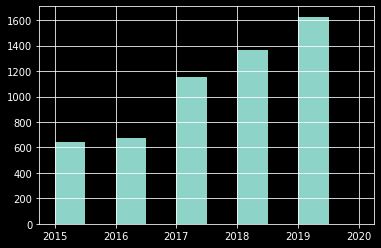

In [152]:
supply.start_year.hist()

Om het nog wat duidelijker te bekijken, gaan we ook de waardes van dichterbij bekijken. 

In [153]:
supply.start_year.value_counts()

2019    1627
2018    1362
2017    1152
2016     675
2015     641
2020       1
Name: start_year, dtype: int64

Zelfs als we rekening houden met het feit dat er in de beginjaren (het FAGG begon in 2014 met het bijhouden van deze cijfers) mogelijk nog niet heel veel werd gemeld, zien we een duidelijke stijging: meer dan een verdubbeling van het aantal meldingen in 2018 tov 2015. En 2019 zit nu al op het meest aantal meldingen, hoewel dit jaar nog niet om is.

### Conclusie: er worden steeds vaker medicijntekorten gemeld.

## Welke redenen komen het meest voor bij gemelde tekorten?
Hiervoor kijken we naar de kolom 'supply problem reason'. 

In [154]:
supply.supply_problem_reason.value_counts()

New batch(es) not yet available                  2819
Production problems                               893
Logistic problems                                 126
Other reason                                      110
Temporary suspension of the commercialisation      41
Packaging problems                                 30
FMD - Serialisation                                21
FMD - Serialisation                                11
Patent dispute                                      6
Patent protection                                   5
Name: supply_problem_reason, dtype: int64

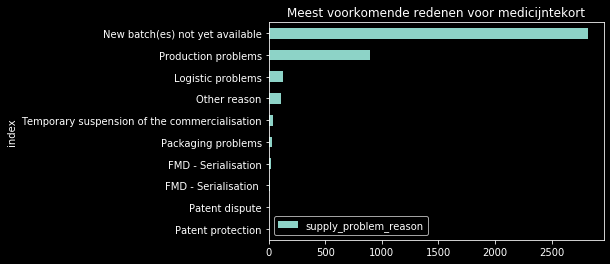

In [155]:
supply.supply_problem_reason.value_counts().reset_index().set_index('index').sort_values(by='supply_problem_reason').plot.barh(title='Meest voorkomende redenen voor medicijntekort')

In verreweg de meeste gevallen ging het om problemen met de beschikbaarheid van nieuwe voorraden. Op de tweede plaats ging het om productieproblemen en daarna om logistieke problemen. In een klein aantal gevallen waren er patentproblemen of zelfs een tijdelijke stopzetting van de commercialisatie.

### Conclusie: de meest voorkomende redenen zijn het onbeschikbaar zijn van nieuwe batches, productieproblemen en logistieke problemen. 
#### Het is mogelijk interessant om eens te kijken naar die redenen die juist weinig voorkomen, daar zit namelijk misschien ook wel een verhaal. 

## Welke fabrikanten komen het meest voor?
Hiervoor kijken we naar de column 'mah', de main authorisation holder. 

In [156]:
supply.mah.value_counts().head(10)

Sandoz                          892
Mylan                           725
Pfizer                          552
MSD                             410
Teva                            273
Bayer                           248
Sanofi                          192
GlaxoSmithKline                 158
Eurogenerics Afgekort "E.G."    133
Aspen Pharma Trading            118
Name: mah, dtype: int64

In [157]:
supply.mah.nunique()

151

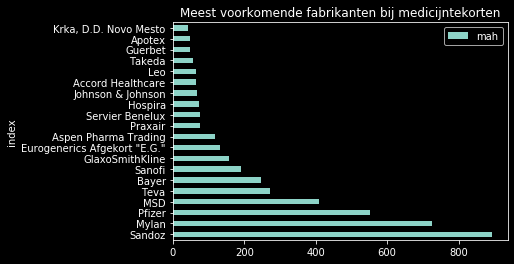

In [158]:
supply.mah.value_counts().reset_index().set_index('index').sort_values(by='mah', ascending=False).head(20).plot.barh(title='Meest voorkomende fabrikanten bij medicijntekorten')

We kijken even waar deze bedrijven vandaan komen. Sandoz is onderdeel van Novartis, een Zwitsers bedrijf. Pfizer is Amerikaans. Mylan staat geregistreerd in Nederland (vermoedelijk vanwege de belastingen, maar dat is een ander verhaal), maar heeft een hoofdzetel in de VS. MSD Belgium is de Belgische tak van een groot Amerikaans bedrijf. Bayer is Duits. Mylan EPD is weer een andere tak van Mylan. Teva Pharma Belgium is een dochteronderneming van het Israëlische Teva Pharmaceuticals. Sanofi Belgium is de Belgische tak van het Franse Sanofi. Eurogenerics is van oorsprong Belgisch en produceert generieke geneesmiddelen. Aspen Pharma Trading is van Aspen Pharmaceuticals, een Zuid-Afrikaans bedrijf.

Vooral interessant is hoe deze absolute cijfers zich verhouden tot het marktaandeel van deze bedrijven op de Belgische en internationale markt. Via de website van het CIB-Pharma vinden we een overzicht met de marktcijfers van het moving annual total van December 2018. Daaruit blijkt dat de top-20 grootste bedrijven op de Belgische markt de volgende zijn:

- EG Generics
- Pfizer
- AbbVie
- Novartis Pharma
- GSK België
- Sandoz
- Brystol-Myers Squibb
- MSD Belgium
- Janssen Pharmaceutica
- Bayer Pharmaceuticals
- Sanofi Belgium
- AstraZeneca
- Boehringer Ingelheim
- Gilead Sciences
- Tadeka Belgium
- Teva Pharmaceuticals Belgium
- Janssen & Janssen Cons
- VIIV Healthcare
- Novo-Nordisk
- Servier
- Gilead Sciences
- Tadeka Belgium
- Teva Pharmaceuticals Belgium
- Janssen & Janssen Cons
- VIIV Healthcare
- Novo-Nordisk
- Servier

Wat dan opvalt is dat hoewel EG Generics het grootste marktaandeel heeft (met afstand), het niet even hoog staat in onbeschikbaarheid van medicijnen. Pfizer staat op beide lijstjes hoog. Mylan staat op de derde plek in onbeschikbaarheid, maar heeft slechts een laag marktaandeel (niet in de top-20). MSD België staat wel in de top-20 in beide lijstjes, net als Bayer en Teva Pharma. Het lijkt er dus op dat de tweede grootste bedrijven qua tekorten (Pfizer en Sandoz) ook relatief hoog in het marktaandeel zitten (tweede en zesde plek). Vooral Sandoz komt heel vaak voor. 

Kanttekening hier: het kan dus zijn dat dit vooral komt omdat de bedrijven het goed rapporteren, niet per se omdat zij ook het hoogste aandeel hebben. Al is het wel opvallend dat het aantal gemelde tekorten van Sandoz bijna twee keer zo groot is als van Pfizer. 

### Conclusie: De twee bedrijven met de hoogste tekorten staan ook hoog in de top-20 qua marktaandeel in 2018, verder is het een mix. Het is waarschijnlijk interessanter om te gaan kijken naar cross-checks, zoals welke medicijntypes veel tekort worden gemeld, of welke bedrijven steeds langere/vaker tekorten melden. 

## Welke medicijnen en medicijntypes komen het meeste voor?
Hiervoor moeten we allereerst kijken naar de meest voorkomende stofnamen/merknamen, en deze vervolgens koppelen aan het juiste type medicijn.

In [159]:
supply.name.value_counts()

Oxygène                    77
Ultravist                  43
Ranitidine                 37
Bisoprolol                 36
Lipitor                    32
Iomeron                    31
Valtran                    29
Zantac                     29
Serlain                    27
Valsartan                  27
Quetiapine                 27
Dalacin                    27
Quetiapin                  26
Tadalafil                  26
Celecoxib                  26
Aciclovir                  26
Loortan                    26
Co-Valsartan               26
Mirtazapine                25
Gadovist                   25
Olmesartan                 24
Ibuprofen                  24
Diflucan                   24
Sildenafil                 23
Paroxetine                 23
Euthyrox                   23
Zolmitriptan               23
Amlor                      22
Metoprolol                 22
Medrol                     22
                           ..
Dehydrobenzperidol          1
Alcaine                     1
Lipiodol  

In [160]:
supply.name_medicinal_product.value_counts()

Oxygène Médicinal Liquide Praxair 100 % v/v    77
Gadovist 1,0 mmol/ml                           25
Ultravist 300 300 mg/ml                        24
Ultravist 370 370 mg/ml                        18
Valtran 71,197 mg/ml - 6,083 mg/ml             18
Cerazette 75 µg                                17
Lueva 75 µg                                    16
Serlain 50 mg                                  15
Amlor 5 mg                                     15
Iomeron 400 mg I/ml                            15
Marvelon 0,150 mg - 0,030 mg                   15
Mercilon 0,150 mg - 0,020 mg                   14
Eusaprim Forte 160 mg - 800 mg                 13
Desloratadin Sandoz 5 mg                       13
Zantac 150 mg                                  12
Clozan 5 mg                                    12
Medrol A 16 mg                                 12
Lipanthylnano 145 mg                           11
Campral 333 mg                                 11
Trazolan 100 mg                                11


We willen deze twee (name en name_medical_product) vergelijken omdat soms de naam van het product hetzelfde is, maar de precieze dosis niet. We zien dit meteen terug bij Ultravist: staat er 41 keer in, 22 keer met 300 mg/ml, 18 keer met 370 mg/ml. Als deze tekorten tegelijkertijd voorkomen, is het interessant om te zien of dit betekent dat een volledig medicijn niet meer beschikbaar is (een van onze andere vragen). We gaan ons eerst focussen op de medicijntypes, en daar hebben we de specifieke dosis niet voor nodig. We kijken dus alleen naar de eerste naam. 

In [161]:
supply.name.value_counts().reset_index().rename(columns={'index':'name', 'name':'count'}).to_csv('zorg/medicijnen.csv', index=False)